# Traits prediction in Tsetse flies uisng restirctied number of wavenumbers
Final jupyter notebook for sex, and age prediction of males and females flies using the infrared region from 1750-602 cm-1. This notebooks creates the models and reproduces figure 5 and figure S3 of the manuscript. 

## Changelog

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# import packages

import sys

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import joblib


from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay


sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import model_optimization
from utilities import train_model
from utilities import test_model

In [70]:
colors = sn.color_palette("Set2") 

In [71]:
tsetse_data = pd.read_csv("../data/processed/TseTse_processed.csv")

In [72]:
df_ic = pd.DataFrame(tsetse_data.groupby(['Sex','Age','Tissue'])['ID'].count())
df_ic

ID
Sex Age Tissue      
f   3d  Abdomen   48
        Head     133
        Thorax   136
    5w  Abdomen   16
        Head      92
        Thorax    96
    7w  Abdomen   38
        Head     120
        Thorax   122
m   5w  Head      94
        Thorax    93
    7w  Abdomen   15
        Head      93
        Thorax    92

In [73]:
tsetse_data_sameages = tsetse_data[(tsetse_data["Age"]!= '3d')]
tsetse_data_sameages_copy = tsetse_data_sameages.copy()

tsetse_thorax = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Thorax']
tsetse_head = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Head']

## Sex prediction

In [74]:
X_sex_thorax = tsetse_thorax.loc[:,"1750":"602"]
y_sex_thorax = tsetse_thorax.loc[:,"Sex"]

X_sex_head = tsetse_head.loc[:,"1750":"602"]
y_sex_head = tsetse_head.loc[:,"Sex"]

In [75]:
waveNumslist = X_sex_thorax.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [76]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_sex_thorax, y_sex_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_sex_head, y_sex_head, test_size=0.2, shuffle=True, random_state=123)

In [77]:
sex_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
sex_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [78]:
sex_data_plot_thorax = dataplotmelt(sex_thorax_acc_baseline)
sex_data_plot_head = dataplotmelt(sex_head_acc_baseline)

In [79]:
# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)
# thorax
best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [80]:
# Train the best model
sex_model_head=train_model(X_hd_train,y_hd_train, best_model_head,'sex_head_informative')
sex_model_thorax=train_model(X_th_train,y_th_train, best_mdoel_thorax,'sex_thorax_informative')

In [118]:
#test model
loaded_model_sex_head = joblib.load('../results/models/trained_model_sex_head_informative.sav')
loaded_model_sex_thorax = joblib.load('../results/models/trained_model_sex_thorax_informative.sav')

y_sex_head_pred, y_sex_head_prob = test_model(X_hd_test, y_hd_test, loaded_model_sex_head)

y_sex_thorax_pred, y_sex_thorax_prob = test_model(X_th_test, y_th_test, loaded_model_sex_thorax)

Accuracy on test set using the head: 0.9625
Accuracy on test set using the head: 0.9012345679012346


## Male age prediction

In [82]:
tsetse_males_thorax = tsetse_data.loc[(tsetse_data['Sex'] == 'm') & (tsetse_data['Tissue'] == 'Thorax')]

tsetse_males_head = tsetse_data.loc[(tsetse_data['Sex'] == 'm') & (tsetse_data['Tissue'] == 'Head')]

In [83]:
X_males_thorax = tsetse_males_thorax.loc[:,"1750":"602"]
X_males_head = tsetse_males_head.loc[:,"1750":"602"]

y_males_thorax = tsetse_males_thorax.loc[:,"Age"]
y_males_head = tsetse_males_head.loc[:,"Age"]

In [84]:
Xm_th_train, Xm_th_test, ym_th_train, ym_th_test = train_test_split(X_males_thorax, y_males_thorax, test_size=0.2, shuffle=True, random_state=123)

Xm_hd_train, Xm_hd_test, ym_hd_train, ym_hd_test = train_test_split(X_males_head, y_males_head, test_size=0.2, shuffle=True, random_state=123)

In [85]:
males_thorax_acc_baseline = baseline_accuracy(Xm_th_train, ym_th_train)
males_head_acc_baseline = baseline_accuracy(Xm_hd_train,ym_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [86]:
males_data_plot_thorax = dataplotmelt(males_thorax_acc_baseline)
males_data_plot_head = dataplotmelt(males_head_acc_baseline)

In [87]:
# model optimization

males_best_model_head = model_optimization(Xm_hd_train,ym_hd_train)
males_best_model_thorax = model_optimization(Xm_th_train, ym_th_train)

Best model parameters{'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [88]:
# Train the best model
train_model(Xm_hd_train,ym_hd_train, males_best_model_head,"head_male_informative")
train_model(Xm_th_train,ym_th_train,males_best_model_thorax,"thorax_male_informative")

In [89]:
#test model
loaded_model_males_head = joblib.load('../results/models/trained_model_head_male_informative.sav')

loaded_model_males_thorax = joblib.load('../results/models/trained_model_thorax_male_informative.sav')

In [90]:
y_male_head_pred, y_male_head_prob = test_model(Xm_hd_test, ym_hd_test, loaded_model_males_head)

y_male_thorax_pred, y_male_thorax_prob = test_model(Xm_th_test, ym_th_test, loaded_model_males_thorax)

Accuracy on test set using the head: 0.9473684210526315
Accuracy on test set using the head: 0.8648648648648649


## Female age prediction

In [91]:
tsetse_females_thorax = tsetse_data.loc[(tsetse_data['Sex'] == 'f') & (tsetse_data['Tissue'] == 'Thorax')]

tsetse_females_head = tsetse_data.loc[(tsetse_data['Sex'] == 'f') & (tsetse_data['Tissue'] == 'Head')]

In [92]:
X_females_thorax = tsetse_females_thorax.loc[:,"1750":"602"]
X_females_head = tsetse_females_head.loc[:,"1750":"602"]

y_females_thorax = tsetse_females_thorax.loc[:,"Age"]
y_females_head = tsetse_females_head.loc[:,"Age"]

In [93]:
Xf_th_train, Xf_th_test, yf_th_train, yf_th_test = train_test_split(X_females_thorax, y_females_thorax, test_size=0.2, shuffle=True, random_state=123)

Xf_hd_train, Xf_hd_test, yf_hd_train, yf_hd_test = train_test_split(X_females_head, y_females_head, test_size=0.2, shuffle=True, random_state=123)

In [94]:
females_thorax_acc_baseline = baseline_accuracy(Xf_th_train, yf_th_train)
females_head_acc_baseline = baseline_accuracy(Xf_hd_train,yf_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [95]:
females_data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
females_data_plot_head = dataplotmelt(females_head_acc_baseline)

In [96]:
# model optimization

females_best_model_head = model_optimization(Xf_hd_train,yf_hd_train)
females_best_model_thorax = model_optimization(Xf_th_train, yf_th_train)

Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [97]:
# Train the best model
train_model(Xf_hd_train,yf_hd_train, females_best_model_head,"head_female_informative")
train_model(Xf_th_train,yf_th_train, females_best_model_thorax,"thorax_female_informative")

In [98]:
#test model
loaded_model_females_head = joblib.load('../results/models/trained_model_head_female_informative.sav')

loaded_model_females_thorax = joblib.load('../results/models/trained_model_thorax_female_informative.sav')

In [99]:
y_female_head_pred, y_female_head_prob = test_model(Xf_hd_test, yf_hd_test, loaded_model_females_head)

y_female_thorax_pred, y_female_thorax_prob = test_model(Xf_th_test, yf_th_test, loaded_model_females_thorax)

Accuracy on test set using the head: 0.8260869565217391
Accuracy on test set using the head: 0.8732394366197183


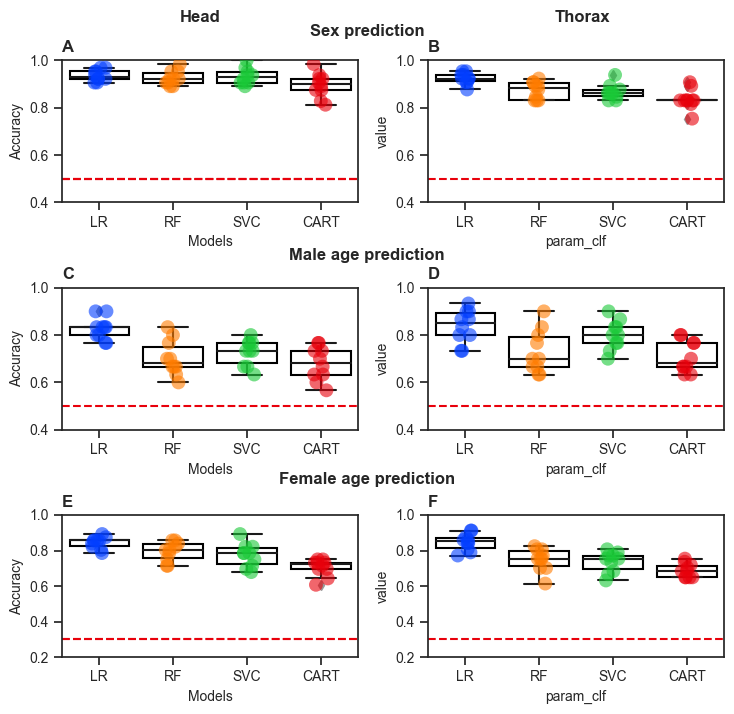

In [100]:
# Figure 4

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":10,
    'xtick.labelsize':10,
    'ytick.labelsize':10}

sn.set_style("ticks")
sn.set_context('notebook', rc=rc)
sn.set_palette('bright', color_codes=True)

fig, ((ax, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(7.5,7), tight_layout=False)

plt.subplots_adjust(hspace=0)


# Sex prediction
sn.boxplot(data=sex_data_plot_head, x='param_clf',y='value',ax=ax, color='white')
sn.stripplot(data=sex_data_plot_head, x='param_clf',y='value',ax=ax,size=10, hue='param_clf', alpha=0.6, legend=False)
plt.setp(ax.lines, color='k')

for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)


sn.boxplot(data=sex_data_plot_thorax, x='param_clf',y='value',ax=ax2, color='white')
sn.stripplot(data=sex_data_plot_thorax, x='param_clf',y='value',ax=ax2,size=10, hue='param_clf', alpha=0.6, legend=False)
plt.setp(ax2.lines, color='k')

for l, box in enumerate(ax2.patches):
    box.set_edgecolor('black')

ax2.axhline(0.5, color='r', ls='--')
ax2.set_ylim(0.4,1)





# Male age prediction
sn.boxplot(data=males_data_plot_thorax, x='param_clf',y='value',ax=ax4, color='white')
sn.stripplot(data=males_data_plot_thorax, x='param_clf',y='value',ax=ax4,size=10, hue='param_clf', alpha=0.6, legend=False)
plt.setp(ax4.lines, color='k')
for l, box in enumerate(ax4.patches):
    box.set_edgecolor('black')

ax4.axhline(0.5, color='r', ls='--')
ax4.set_ylim(0.4,1)


sn.boxplot(data=males_data_plot_head, x='param_clf',y='value',ax=ax3, color='white')
sn.stripplot(data=males_data_plot_head, x='param_clf',y='value',ax=ax3,size=10, hue='param_clf', alpha=0.6, legend=False)
plt.setp(ax3.lines, color='k')
for l, box in enumerate(ax3.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)




# female age prediction
sn.boxplot(data=females_data_plot_head, x='param_clf',y='value',ax=ax5, color='white')
sn.stripplot(data=females_data_plot_head, x='param_clf',y='value',ax=ax5,size=10, hue='param_clf', alpha=0.6, legend=False)
plt.setp(ax5.lines, color='k')
for l, box in enumerate(ax5.patches):
    box.set_edgecolor('black')

ax5.axhline(0.3, color='r', ls='--')
ax5.set_ylim(0.2,1)

sn.boxplot(data=females_data_plot_thorax, x='param_clf',y='value',ax=ax6, color='white')
sn.stripplot(data=females_data_plot_thorax, x='param_clf',y='value',ax=ax6,size=10, hue='param_clf', alpha=0.6, legend=False)
plt.setp(ax6.lines, color='k')
for l, box in enumerate(ax6.patches):
    box.set_edgecolor('black')

ax6.axhline(0.3, color='r', ls='--')
ax6.set_ylim(0.2,1)






# Overall aesthetics and annotations

plots1 = [ax2,ax4,ax6]

plots_g = [ax,ax2,ax3,ax4,ax5,ax6]
abcd = ["A", "B", "C", "D", "E", "F"]

for i,a in zip(plots_g,abcd):
    i.set_title(a, fontweight='bold',loc="left")



plots2 = [ax,ax3]
for i in plots2:
    i.axhline(0.5, color='r', ls='--')
    i.set_ylim(0.4,1)
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")

ax5.axhline(0.3, color='r', ls='--')
ax5.set_ylim(0.2,1)
ax5.set_xlabel("Models")
ax5.set_ylabel("Accuracy")

fig.text(x=0.25,y=1,s="Head",fontweight='bold')
fig.text(x=0.75,y=1,s="Thorax",fontweight='bold')
fig.text(x=0.5,y=0.98,s="Sex prediction",ha='center',fontweight='bold')
fig.text(x=0.5,y=0.66,s="Male age prediction",ha='center',fontweight='bold')
fig.text(x=0.5,y=0.34,s="Female age prediction",ha='center',fontweight='bold')



plt.savefig("../results/plots/FigS2.tiff", dpi=300, bbox_inches='tight')

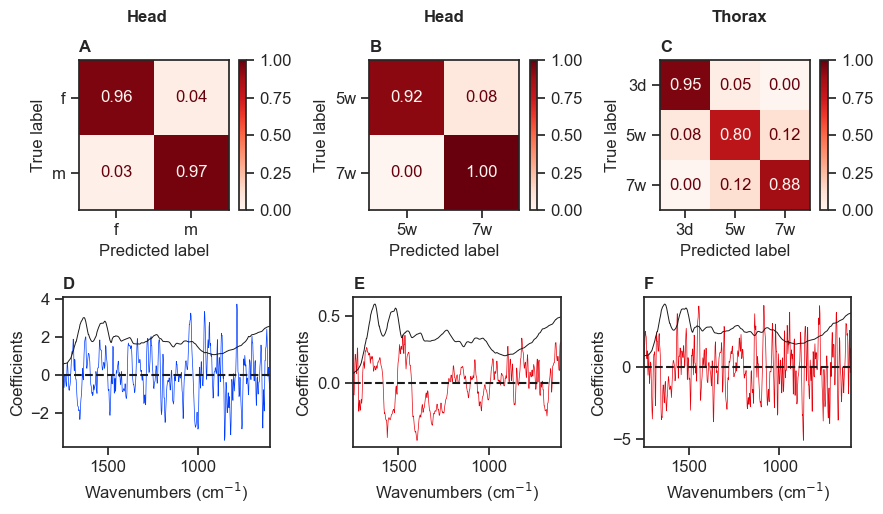

In [115]:
# plot fig5
# Final plot paper
# confusion matrix for head and model coefficients

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )
fig, ((ax, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5), tight_layout=False)

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_sex_head_pred,display_labels=loaded_model_sex_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=wavenumbers,y=loaded_model_sex_head['model'].coef_[0], color='b',ax=ax4, linewidth=0.5)

sn.lineplot(x=wavenumbers, y=(np.mean(X_sex_head ,axis=0)*10),color='k',ax=ax4, linewidth=0.7)

#ax4.set_ylim(-3,4)


# males
disp = ConfusionMatrixDisplay.from_predictions(ym_hd_test,y_male_head_pred,display_labels=loaded_model_males_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})

sn.lineplot(x=wavenumbers,y=loaded_model_males_head['model'].coef_[0], color='r',ax=ax5, linewidth=0.5)
sn.lineplot(x=wavenumbers, y=(np.mean(X_males_head ,axis=0)*2),color='k',ax=ax5, linewidth=0.7)


# females
disp = ConfusionMatrixDisplay.from_predictions(yf_th_test,y_female_thorax_pred,display_labels=loaded_model_females_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax3, im_kw={'vmin':0, 'vmax':1})

sn.lineplot(x=wavenumbers,y=loaded_model_females_thorax['model'].coef_[0], color='r',ax=ax6, linewidth=0.5)
sn.lineplot(x=wavenumbers, y=(np.mean(X_females_thorax ,axis=0)*15),color='k',ax=ax6, linewidth=0.7)


plots = [ax4,ax5,ax6]
for i in plots:
    i.set_xlim(1750,600)
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")
    i.set_ylabel("Coefficients")
    i.axhline(0, ls="--",color='k')

plots_g = [ax,ax2,ax3,ax4,ax5,ax6]
abcd = ["A", "B", "C", "D", "E", "F"]

for i,a in zip(plots_g,abcd):
    i.set_title(a, fontweight='bold',loc="left")

fig.text(x=0.15,y=1,s="Head",fontweight='bold')
fig.text(x=0.48,y=1,s="Head",fontweight='bold')
fig.text(x=0.8,y=1,s="Thorax",fontweight='bold')

plt.savefig("../results/plots/Fig5.tiff", dpi=300,bbox_inches='tight')


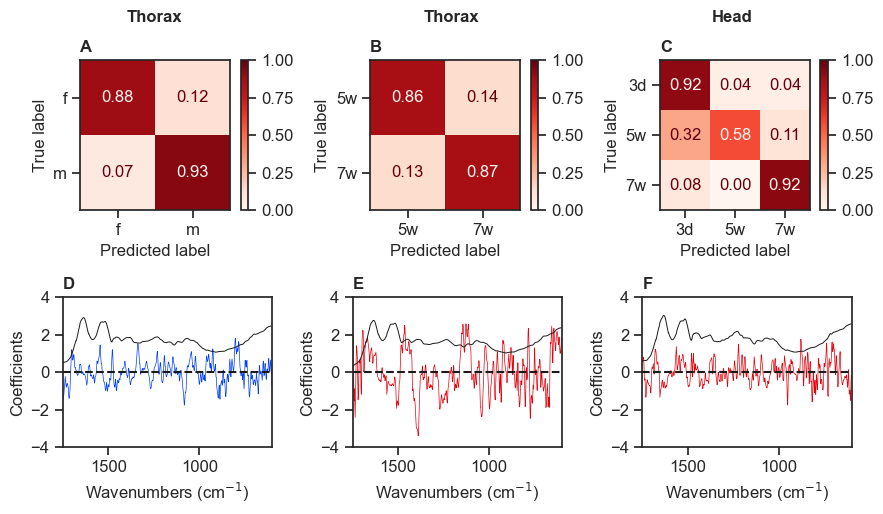

In [127]:
# plot Fig S3
# Final plot paper
# confusion matrix for head and model coefficients

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )
fig, ((ax, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5), tight_layout=False)

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_sex_thorax_pred,display_labels=loaded_model_sex_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})

sn.lineplot(x=wavenumbers,y=loaded_model_sex_thorax['model'].coef_[0], color='b',ax=ax4, linewidth=0.5)

sn.lineplot(x=wavenumbers, y=(np.mean(X_sex_thorax ,axis=0)*10),color='k',ax=ax4, linewidth=0.7)

#ax4.set_ylim(-3,4)


# males
disp = ConfusionMatrixDisplay.from_predictions(ym_th_test,y_male_thorax_pred,display_labels=loaded_model_males_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})

sn.lineplot(x=wavenumbers,y=loaded_model_males_thorax['model'].coef_[0], color='r',ax=ax5, linewidth=0.5)
sn.lineplot(x=wavenumbers, y=(np.mean(X_males_thorax ,axis=0)*10),color='k',ax=ax5, linewidth=0.7)


# females
disp = ConfusionMatrixDisplay.from_predictions(yf_hd_test,y_female_head_pred,display_labels=loaded_model_females_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax3, im_kw={'vmin':0, 'vmax':1})

sn.lineplot(x=wavenumbers,y=loaded_model_females_head['model'].coef_[0], color='r',ax=ax6, linewidth=0.5)
sn.lineplot(x=wavenumbers, y=(np.mean(X_females_head ,axis=0)*10),color='k',ax=ax6, linewidth=0.7)

plots = [ax4,ax5,ax6]
for i in plots:
    i.set_xlim(1750,600)
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")
    i.set_ylabel("Coefficients")
    i.axhline(0, ls="--",color='k')
    i.set_ylim(-4,4)

plots_g = [ax,ax2,ax3,ax4,ax5,ax6]
abcd = ["A", "B", "C", "D", "E", "F"]

for i,a in zip(plots_g,abcd):
    i.set_title(a, fontweight='bold',loc="left")

fig.text(x=0.15,y=1,s="Thorax",fontweight='bold')
fig.text(x=0.48,y=1,s="Thorax",fontweight='bold')
fig.text(x=0.8,y=1,s="Head",fontweight='bold')

plt.savefig("../results/plots/FigS3.tiff", dpi=300,bbox_inches='tight')

